In [13]:
import sys
import os
sys.path.append('D:\\software_git_repos\\Polaris\\polaris_software\\utils_meinhold')
#sys.path.append('../../cofe-python-analysis-tools/utils_meinhold')
sys.path.append('D:\\software_git_repos\\Polaris\\polaris_software\\utils_zonca')
#sys.path.append('../../cofe-python-analysis-tools/utils_zonca')
#sys.path.append('D:\\software_git_repos\\cofe-python-analysis-tools\\utils_zonca\\pointing')
sys.path.append('../../cofe-python-analysis-tools/utils_zonca/pointing')
#sys.path.append('D:\\software_git_repos\\greenpol')
sys.path.append('../')
#sys.path.append('D:\\software_git_repos\\greenpol\\telescope_control\\')
sys.path.append('../telescope_control')
#sys.path.append('D:\\software_git_repos\\greenpol\\telescope_control\\VtoT\\')
sys.path.append('../VtoT')
import convert
import realtime_gp as rt
import numpy as np
import datetime 
import h5py
#import pandas as pd
#from pointingtools import compute_parallactic_angle, altaz2ha 
#from planets import getlocation, getpointing
import warnings
#from astropy.coordinates import AltAz, Angle, EarthLocation, ICRS, SkyCoord, frame_transform_graph
#from astropy import units as u
#import ephem
import matplotlib.pyplot as plt
import time
#import planets
from datetime import timedelta
#import numpy.ma as ma
import cofe_util as cu

import Tkinter,tkFileDialog

from Tkinter import *
import ttk

import pickle
import glob

import cPickle

from scipy.optimize import curve_fit

from uncertainties import ufloat
from uncertainties.umath import *

%pylab

Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib


C:\Users\labuser\anaconda3\envs\py27\lib\site-packages\IPython\core\magics\pylab.py:161: UserWarning: pylab import has clobbered these variables: ['fmod', 'sinh', 'trunc', 'Text', 'tan', 'gamma', 'cosh', 'radians', 'sin', 'expm1', 'ldexp', 'Button', 'exp', 'frexp', 'ceil', 'copysign', 'Widget', 'degrees', 'cos', 'tanh', 'fabs', 'sqrt', 'hypot', 'log', 'log10', 'log1p', 'floor', 'modf', 'isinf', 'isnan']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [14]:
def get_pointing_files(filelist=None):

    if filelist==None:
        root=Tkinter.Tk()
        filelist = list(tkFileDialog.askopenfilenames(\
        initialdir='D://software_git_repos/Polaris/polaris_data/pointing_data/',parent=root,title='Choose a set of files'))
        root.destroy()
    filelist.sort()
    
    return filelist

In [15]:
def read_some_data(datadict,datalabel,datatype='demod', filelist=None):

    if filelist==None:
        root=Tkinter.Tk()
        if datatype=='demod':
            filelist = list(tkFileDialog.askopenfilenames(\
            initialdir='D://software_git_repos/Polaris/polaris_data/demod_data/',parent=root,title='Choose a set of files'))
        if datatype=='raw':
            filelist = list(tkFileDialog.askopenfilenames(\
            initialdir='D://software_git_repos/Polaris/polaris_data/data/',parent=root,title='Choose a set of files'))            
        root.destroy()
    filelist.sort()
    
    if datatype=='demod':
        dlist=[]
        for f in filelist:
            hf=h5py.File(f)
            dlist.append(hf['demod_data'])
        d=concatenate(dlist)
        hf.close() 
        
    if datatype=='raw':
        d=rt.demod.read_raw(filelist)
    datadict[datalabel]=d
    return

In [16]:
def get_file_times(fld):
    startfile = fld[0][:65]+fld[0][71:-2]+'dat'
    endfile = fld[-1][:65]+fld[-1][71:-2]+'dat'
    
    #starttime = os.path.getctime(startfile)
    starttime= os.stat(startfile).st_mtime
    starttime = datetime.datetime.fromtimestamp(starttime)

    #endtime = os.path.getctime(endfile)
    endtime= os.stat(endfile).st_mtime
    endtime = datetime.datetime.fromtimestamp(endtime)
    
    return starttime, endtime

In [17]:
def plot_toi_dict(toi_dict,chanlist=['H1HiAC'],componentlist=['T'],datalist=None, kperv=[1]):
    #function to give a choice of preloaded datasets from dictionary data_dict
    figure()
    if datalist==None:
        datalist=toi_dict.keys()
    if len(componentlist)==1:  # if componentlist is a single value, assume same thing for all chans
        c=componentlist[0]
        componentlist=[c for n in chanlist]
    #set up the color sequence for the plot
    nlines=len(datalist)*len(chanlist)
    colormap = cm.gist_ncar
    gca().set_color_cycle([colormap(i) for i in np.linspace(0, 0.9, nlines)])
    titletxt=[]
    count = 0
    for dname in datalist:
        samprate=1000./(toi_dict[dname]['rev'][1]-toi_dict[dname]['rev'][0])
        titletxt.append(dname)
        for channame,component in zip(chanlist,componentlist):
            try:
                toi=toi_dict[dname][rt.nametochan(channame)][component] #if it's demod data so a dict
                print dname + channame + ' mean value: ', toi.mean()
                t=toi_dict[dname]['azi'][0]+arange(len(toi))/samprate
                if len(kperv)==1 and kperv[0]==1.0:
                    plot(t,toi*kperv[count],label=dname+ '  '+channame+' '+component,lw=2)
                else:
                    plot(t,toi*kperv[count],label=dname+ '  '+channame+' '+component+' gain= '+str(kperv[count]),lw=2)
                if (count+1) < len(kperv):
                    count += 1
            except:
                toi=toi_dict[dname][rt.nametochan(channame)].flatten()#if it's raw data so not a dict
                print dname + ' ' + channame + ' mean value: ', toi.mean()
                t=toi_dict[dname]['azi'][0]+arange(len(toi))/(256.*samprate)
                if len(kperv)==1 and kperv[0]==1.0:
                    plot(t,toi*kperv[count],label=dname+ '  '+channame+' '+component,lw=2)
                else:
                    plot(t,toi*kperv[count],label=dname+ '  '+channame+' '+component+' gain= '+str(kperv[count]),lw=2) 
                if (count+1) < len(kperv):
                    count += 1
                
    title(titletxt)
    legend()
    xlabel('Time [S]')
    if len(kperv) == 1 and kperv[0] == 1:
        ylabel('Output [v]')
    else:
        ylabel('Output [T]')

In [18]:
def asd_from_dict(data_dict,minfreq=1.):
    #run nps on all the channels for each of the loaded data sets, return asd dictionary
    asd_dict={}
    chans=['ch%s' %str(i) for i in range(16)]
    for datset in data_dict.keys():
        asd_dict[datset]={}
        datatype='demod'
        print(datset)
        d=data_dict[datset]
        if len(d.dtype)==18:
            datatype='raw'
        samprate=1000./float(d['rev'][10]-d['rev'][9])
        for chan in chans:
            if datatype=='raw':
                freq,psd=cu.nps(d[chan].flatten(),samprate*256,minfreq=minfreq)
                asd_dict[datset]['freq']=freq
                asd_dict[datset][chan]=sqrt(psd)
            if datatype=='demod':
                asd_dict[datset][chan]={}
                for component in ['T','Q','U']:
                    freq,psd=cu.nps(d[chan][component],samprate,minfreq=minfreq)
                    asd_dict[datset][chan][component]=sqrt(psd)
                    asd_dict[datset]['freq']=freq
                    
    return asd_dict            

In [19]:
def plot_asd_dict(asd_dict,chanlist=['H1HiAC'],componentlist=['T'],datalist=None,kperv=[1], LABEL = None, TITLE=None, color = None):
    #function to give a choice of preloaded datasets from dictionary data_dict
    figure()
    if datalist==None:
        datalist=asd_dict.keys()
    if len(componentlist)==1:  # if componentlist is a single value, assume same thing for all chans
        c=componentlist[0]
        componentlist=[c for n in datalist]
    #set up the color sequence for the plot
    nlines=len(datalist)*len(chanlist)
    colormap = cm.gist_ncar
    gca().set_color_cycle([colormap(i) for i in np.linspace(0, 0.9, nlines)])
    
    count = 0
    for dname in datalist:
        for channame,component in zip(chanlist,componentlist):
            try:
                asd=asd_dict[dname][rt.nametochan(channame)][component] #if it's demod data so a dict
            except:
                asd=asd_dict[dname][rt.nametochan(channame)]           #if it's raw data so not a dict
            if LABEL == None:
                    LABEL = dname+ '  '+channame+' '+component
            else:
                label = LABEL[count]
                    
            if color == None:
                if len(kperv) == 1 and kperv[0] == 1.0:
                    plot(asd_dict[dname]['freq'],asd*kperv[count],label=label,lw=2)
                else:
                    plot(asd_dict[dname]['freq'],asd*kperv[count],label=label,lw=2)
                    
            else:
                if len(kperv) == 1 and kperv[0] == 1.0:
                    plot(asd_dict[dname]['freq'],asd*kperv[count], color[count],label=label,lw=2)
                else:
                    plot(asd_dict[dname]['freq'],asd*kperv[count], color[count],label=label,lw=2)
            if (count+1) < len(kperv):
                count += 1
    legend()
    xlabel('Frequency [Hz]')
    title(TITLE)
    if len(kperv) == 1 and kperv[0] == 1:
        ylabel(r'ASD [$\frac{V}{\sqrt{Hz}}$]')
    else:
        ylabel(r'ASD [$\frac{K}{\sqrt{Hz}}$]')

In [20]:
def get_h5_pointing_simple(filelist,startrev=None, stoprev=None,angles_in_ints=False,azel_era=3):
    """
        modify to fast version, dont' average the multiple values, just take the first one. will cause a little bias but its very fast.
    also implmented removal of erroneous endof h5 file crap, and az outliers
    azel_era determines what az/el offsets to use, 1 means before 9/26/2013, 2 means 9/26-10/3 (inclusive), 3 means after 10/4.
    """

    #filelist is complete path list to the h5 files
    elconversion=-360./40000.
    azconversion=-360./(2.**16)
    #eloffset=8.2-3.17382
    #eloffset=5.026 # correction from 2013/08/02 moon crossing for both az and el this for ch 3! 
    #azoffset=4.41496
    # on 2013/08/20, updated converter.py to include these offsets, in theory they should now be zero.
    eloffset =0.0
    azoffset=0.0
    #ch1 would be azoffset=198.7810-187.663   or 11.118
    #             eloffset= 8.2-5.69175  
    #             eloffset= 2.5082
    #note October 4, 2013. Just found that data from 9/26/13 through 10/04/13 used old converter.py. So special 
    #offsets needed:
    #update, 10/8/13. ran get_cofe_crossing on second sun crossing from 10/04 (after subtracting 
    #template estimate of satellites,important effect). delta offsets: az=2.10,el=0.934
    #these then would be future offsets
    #update, 11/19/13. Ran mapmaking on lots of days, found an offset in the two daily crossings of the Crab- used ephem
    #to find the crossings, found that should get a self-consistent solution for both if the azimth is reduced by 4.51 degrees
    #and the elevation is increased by  2.241 degrees.
    '''
    if azel_era==1:
        eloffset=5.026
        azoffset=4.41496+140.0
    if azel_era==2:
        eloffset=5.026+0.934
        azoffset=4.41496+140.0+2.1
    if azel_era==3:
        eloffset=0.934+2.241
        azoffset=2.10 -4.51
    '''



    errlimit=0.1
    
    #if angles_in_ints==True:
    #    errlimit=10
    hpointing=[]
    filelist.sort()
    for f in filelist:
        if f[79:88] != 'corrected':
            slimit = 22144
        else:
            slimit = 11512
        stats=os.stat(f)
        if stats.st_size<slimit:
            print f,stats.st_size
        if stats.st_size >= slimit:
            h=h5py.File(f)
            hh=h['data']
            hpointing.append(hh[hh['gpstime']>=hh['gpstime'][0]])
            #print hpointinng
            h.close()

    hpointing = np.concatenate(hpointing)
    #cut out blank lines from unfilled files
    '''if startrev != None:
        hpointing=hpointing[hpointing['gpstime'] > startrev]
    if stoprev != None:
        hpointing=hpointing[hpointing['gpstime'] < stoprev]'''

    #hrevlist,inds=np.unique(hpointing['gpstime'],return_index=True)
    
    hrevlist = hpointing['gpstime']

    psize = len(hpointing['el'])#[inds])

    elmeans=hpointing['el']#[inds]
    azmeans=hpointing['az']#[inds]
    h1means = hpointing['H1']#[inds]
    h2means = hpointing['H2']#[inds]
    h3means = hpointing['H3']#[inds]
    cryo1means = hpointing['Backend TSS']#[inds]
    cryo2means = hpointing['Amplifier']#[inds]
    cryo3means = hpointing['Cooler']#[inds]
    cryo4means = hpointing['Calibrator']#[inds]
    azlevmeans = hpointing['x tilt']#[inds]
    ellevmeans = hpointing['y tilt']#[inds]
    try:
        azoffsetmeans = hpointing['az offset']#[inds]
    except:
        azoffsetmeans = np.zeros(psize)
    try:
        eloffsetmeans = hpointing['el offset']#[inds]
    except:
        eloffsetmeans = np.zeros(psize)
    try:
        comptimemeans = hpointing['computer time']#[inds]
    except:
        comptimemeans = np.zeros(psize)
    try:
        flagmeans = hpointing['flag']#[inds]
    except:
        flagmeans = np.zeros(psize)
    try:
        phtempmeans = hpointing['Phidget Temp']#[inds]
    except:
        phtempmeans = np.zeros(psize)
    #("az offset", np.float), ("el offset", np.float), ("computer time", np.float), ("flag", np.int)])

    #get rid of az outliers:

    azmeans=np.mod(azmeans+azoffset,360.)
    elmeans=np.mod(elmeans+eloffset,90.)
    daz=np.diff(azmeans)

    maxstep = 5.
    badaz=np.unique(np.where(np.logical_and((np.abs(daz) > maxstep) , (np.abs(daz+359.5) > maxstep)))[0])
    '''if len(badaz > 1):
        if (badaz[-1]-len(daz) < 3):
            badaz=badaz[:-1]
        if (badaz[0] < 3):
            badaz=badaz[1:]
        azmeans[badaz]=(azmeans[badaz-2]+azmeans[badaz+2])/2.0'''
    azmeans=np.mod(azmeans,360.)
    return {'el':elmeans,'az':azmeans,'gpstime':hrevlist, 'H1':h1means
            , 'H2':h2means, 'H3':h3means, 'Backend TSS':cryo1means
        , 'Amplifier':cryo2means, 'Cooler':cryo3means, 'Calibrator':cryo4means
        , 'x tilt':azlevmeans, 'y tilt':ellevmeans, 'az offset':azoffsetmeans, 'el offset':eloffsetmeans, 'computer time':comptimemeans
        , 'flag':flagmeans, 'Phidget Temp':phtempmeans }


In [21]:
ddict={}

In [90]:
read_some_data(ddict,'skydip', datatype='demod')

In [31]:
ddict.keys()

['skydip', 'sky', 'par', 'amb', 'sky_demod']

In [48]:
beta_h1 = (ddict['nocalch1'][rt.nametochan('H1HiAC')]['Q'].mean() - ddict['pcalch1'][rt.nametochan('H1HiAC')]['Q'].mean())/ddict['nocalch1'][rt.nametochan('H1HiAC')]['Q'].mean()
print(beta_h1)
beta_h2 = (ddict['nocalch2'][rt.nametochan('H2HiAC')]['Q'].mean() - ddict['pcalch2'][rt.nametochan('H2HiAC')]['Q'].mean())/ddict['nocalch2'][rt.nametochan('H2HiAC')]['Q'].mean()
print(beta_h2)
beta_h3 = (ddict['nocalch3'][rt.nametochan('H3HiAC')]['Q'].mean() - ddict['pcalch3'][rt.nametochan('H3HiAC')]['Q'].mean())/ddict['nocalch3'][rt.nametochan('H3HiAC')]['Q'].mean()
print(beta_h3)

KeyError: 'nocalch1'

In [160]:
beta = {}
for i in range(1,4):
    nocal = ddict['nocalch%d' % i][rt.nametochan('H%dHiAC' % i)]['Q'].mean()
    pcal = ddict['pcalch%d' % i][rt.nametochan('H%dHiAC' % i)]['Q'].mean()
    
    nocal_std = ddict['nocalch%d' % i][rt.nametochan('H%dHiAC' % i)]['Q'].std()
    pcal_std = ddict['pcalch%d' % i][rt.nametochan('H%dHiAC' % i)]['Q'].std()
    
    BETA = (nocal - pcal)/nocal
    
    beta_std = (pcal/nocal)*np.sqrt((pcal_std/pcal)**2 + (nocal_std/nocal)**2)
    
    beta['H%d' % i] = ufloat(BETA, beta_std)
    
    print 'Horn %d beta: %.3f +/- %.3f' % (i, BETA, beta_std)

Horn 1 beta: 0.125 +/- 0.008
Horn 2 beta: 0.127 +/- 0.003
Horn 3 beta: 0.114 +/- 0.023


In [32]:
beta = {}
beta['H1'] = ufloat(0.125,0.008)
beta['H2'] = ufloat(0.127,0.003)
beta['H3'] = ufloat(0.114,0.023)

In [111]:
asd_dict = asd_from_dict(ddict, minfreq=0.1)

skydip
sky
par
amb
sky_demod


In [34]:
%matplotlib auto

Using matplotlib backend: Qt5Agg


In [33]:
plot_asd_dict(asd_dict,chanlist=['H1HiAC'],componentlist=['T'],datalist=['amb', 'par', 'sky']
              , kperv = [4.11, 4.11, 4.11], LABEL = ['Ambient Calibrator', 'Partial Calibrator', 'Sky at 70 deg elevation'], TITLE = '10 GHz Horn 1 raw data, Greenland 08/06/2018')

C:\Users\labuser\anaconda3\envs\py27\lib\site-packages\ipykernel_launcher.py:12: MatplotlibDeprecationWarning: The set_color_cycle function was deprecated in version 1.5. Use `.set_prop_cycle` instead.
  if sys.path[0] == '':


In [67]:
ddict.keys()

['encoder_sky1',
 'encoder_sky2',
 'emulator_sky1',
 'emulator_sky2',
 'amb',
 'sky',
 'emulator_sky3']

In [35]:
pp = {}

In [88]:
flp = get_pointing_files()

In [89]:
pp['skydip'] = rt.get_h5_pointing(flp)
gpstime = (pp['skydip']['gpstime'] - pp['skydip']['gpstime'][0])/1000./3600.

In [74]:
plt.figure()
plt.plot(pp['sky']['gpstime'])

In [64]:
flp_sky = get_pointing_files()
pp['sky'] = rt.get_h5_pointing(flp_sky)

In [65]:
pp['sky'].keys()

['gpstime',
 'el',
 'computer time',
 'el offset',
 'Calibrator',
 'H2',
 'H3',
 'H1',
 'Amplifier',
 'az offset',
 'Cooler',
 'flag',
 'x tilt',
 'Phidget Temp',
 'y tilt',
 'az',
 'Backend TSS']

In [40]:
#plt.figure()
diff = np.diff(pp['sky']['az'])
iwrap = np.where(abs(diff) > 180)[0]
pp['sky']['az'][iwrap[0]+1:iwrap[1]+1]

IndexError: index 0 is out of bounds for axis 0 with size 0

In [165]:
plt.figure()
aztilt = pp['sky']['az'][iwrap[0]+1:iwrap[1]+1]
xtilt = pp['sky']['x tilt'][iwrap[0]+1:iwrap[1]+1]
ytilt = pp['sky']['y tilt'][iwrap[0]+1:iwrap[1]+1]
xoffset = (xtilt.max()-xtilt.min())/2
yoffset = (ytilt.max()+ytilt.min())/2
plt.plot(aztilt, xtilt-xoffset, 'k-', label='x tilt')
plt.plot(aztilt, ytilt-yoffset, 'r-', label='y tilt')
plt.xlabel('azimuth (deg)')
plt.ylabel('tilt (deg)')
plt.legend()

In [50]:
pp['skydip'].keys()

['gpstime',
 'el',
 'computer time',
 'el offset',
 'Calibrator',
 'H2',
 'H3',
 'H1',
 'Amplifier',
 'az offset',
 'Cooler',
 'flag',
 'x tilt',
 'Phidget Temp',
 'y tilt',
 'az',
 'Backend TSS']

In [91]:
combined = rt.combine_cofe_h5_pointing(ddict['skydip'], pp['skydip'])

In [102]:
el = combined['el']
chan = 'H1HiDC'
var = 'T'
data = -combined['sci_data'][rt.nametochan(chan)][var]

In [103]:
plt.figure()
plt.plot(data)

In [104]:
def func(el, Vsys, Vz):
    return Vsys + Vz/np.sin(el)

In [105]:
popt, pcov = curve_fit(func, np.radians(el), data)
perr = np.sqrt(np.diag(pcov))

In [106]:
print popt, np.sqrt(np.diag(pcov))

[0.12426068 0.01172411] [4.17901353e-05 1.30872212e-05]


In [107]:
figure()
plot(el, data, 'b-', linewidth=2, label='%s %s' % (chan, var))
plot(el, func(np.radians(el), *popt), 'r-', label='fit: Vsys=%.3f V, Vz=%.3f V' % tuple(popt))
ylabel('Signal (Volts)')
xlabel('Elevation (deg)')
legend()

In [16]:
#now get par cal and clear sky voltages and plug into notebook equation to get gain
#beta = {'H1': 0.12419560576729863, 'H2':0.12628101445342926, 'H3': 0.11703026443075649}

C:\Users\labuser\anaconda3\envs\py27\lib\site-packages\ipykernel_launcher.py:12: MatplotlibDeprecationWarning: The set_color_cycle function was deprecated in version 1.5. Use `.set_prop_cycle` instead.
  if sys.path[0] == '':


amb H3HiDC mean value:  -0.38410409180100313


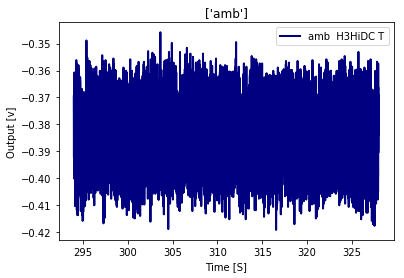

In [12]:
plot_toi_dict(ddict,chanlist=['H3HiDC'],componentlist=['T'],datalist=['amb'])

In [128]:
plot_asd_dict(asd_dict,chanlist=['H1HiAC'],componentlist=['T'],datalist=['sky']
              , kperv = [1], LABEL = ['Sky at 70 deg elevation'], TITLE = '')

C:\Users\labuser\anaconda3\envs\py27\lib\site-packages\ipykernel_launcher.py:12: MatplotlibDeprecationWarning: The set_color_cycle function was deprecated in version 1.5. Use `.set_prop_cycle` instead.
  if sys.path[0] == '':


In [157]:
plt.figure()
plt.plot(ddict['sky'][rt.nametochan('H1HiDC')].flatten())

In [125]:
asd = [0.0005,0.0005, 0.0013]
#delta T is 0.005 for sedgwick, 7e-5 for greenland
Vsys = ufloat(popt[0], perr[0])
Vz = ufloat(popt[1], perr[1])
Tamb = ufloat(np.nanmean(pp['skydip']['Calibrator']), np.nanstd(pp['skydip']['Calibrator']))
for chan in ['H1HiDC']:
    
    

    elevation = pp['sky']['el'].mean()

    try:
        Vpar = ddict['par'][rt.nametochan(chan)][var].mean()
        Vsky = ddict['sky'][rt.nametochan(chan)][var].mean()
        
    except:
        Vpar = ddict['par'][rt.nametochan(chan)].flatten().mean()
        Vsky = ddict['sky'][rt.nametochan(chan)].flatten().mean()

    h = int(chan[1])   

    Vpar_lin = rt.linearize_Vexp(Vpar, h)
    Vsky_lin = rt.linearize_Vexp(Vsky, h)
    
    b = beta[chan[:2]]

    gain = b*Tamb/(Vpar_lin - Vsky_lin + b*(Vz/np.sin(elevation)))
    
    nl = asd[int(chan[1])-1]/np.sqrt(2)
    Tsys = -Vsys*gain
    enl = gain*Vsky_lin/np.sqrt(4e9)

    print b, Tamb, Vz, Vsys
    print 'Horn %s DC Level: ' % h, Vsky_lin, ' V'
    print 'Horn %s partial cal DC Level: ' % h, Vpar_lin, ' V'
    print 'Horn %s DC gain: ' % h, gain, ' K/V'
    print 'Horn %s AC gain: ' % h, gain/30., ' K/V'
    print 'Horn %s Tsky: ' % h, (Vsky_lin - Vsys)*gain, 'K'
    print 'Horn %s Tsys: ' % h, Tsys, 'K'
    print 'Horn %s noise level: ' % h, -nl*1e3*gain/30., ' mK*sqrt(sec)'
    print 'Horn %s expected noise level: ' % h, enl*1e3, ' mK*sqrt(sec)'
    print 'Horn %s effective bandpass: ' % h, -(Vsky_lin/(nl*1e3)), ' GHz'
    #print 'Horn %s sky Temperature:0 ' % h, gain*Vsky_lin, ' K'
    print '--------------------------'

0.125+/-0.008 272.6+/-3.5 0.011724+/-0.000013 0.12426+/-0.00004
Horn 1 DC Level:  -0.13586065764257768  V
Horn 1 partial cal DC Level:  -0.43730643491753984  V
Horn 1 DC gain:  -112+/-7  K/V
Horn 1 AC gain:  -3.75+/-0.24  K/V
Horn 1 Tsky:  29.2+/-1.9 K
Horn 1 Tsys:  14.0+/-0.9 K
Horn 1 noise level:  1.32+/-0.09  mK*sqrt(sec)
Horn 1 expected noise level:  0.241+/-0.016  mK*sqrt(sec)
Horn 1 effective bandpass:  0.38427196926212254  GHz
--------------------------


In [137]:
24./119

0.20168067226890757

In [183]:
deltaV = -0.52
elevation = np.radians(14.2)
print b*Tamb/(deltaV + b*(Vz/np.sin(elevation)))/30.

-2.36307571629


In [ ]:
#if your using ambient load instead of partial cal (which you shouldnt) gain equation is:
# G = Tamb(Vamb-Vsky + Vsys + Vz/sin(elevation))**-1

In [44]:
figure()
plot(ddict['amb'][rt.nametochan(chan)][var].mean())

C:\Users\labuser\Anaconda3\envs\py27\lib\site-packages\ipykernel\__main__.py:2: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  from ipykernel import kernelapp as app


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [48]:
plot_asd_dict(asd_dict,chanlist=['H3HiAC'],componentlist=['T'],datalist=['sky'],kperv=[3.2])

C:\Users\labuser\Anaconda3\envs\py27\lib\site-packages\ipykernel\__main__.py:18: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [33]:
#if you dont have sky dip data:
asd = [0.00125,0.002, 0.007]
Tsky = 20. #guess at Tsky value. Conversly you can use LN2 as your cold source and then you dont have to guess here

for chan in ['H3HiDC']:
    
    Tamb = 287#np.nanmean(pp['skydip']['Calibrator'])
    print Tamb

    #if its demod data
    try:
        Vamb = ddict['amb'][rt.nametochan(chan)][var].mean()
        Vsky = ddict['sky'][rt.nametochan(chan)][var].mean()
    #if its raw data
    except:
        Vamb = ddict['amb'][rt.nametochan(chan)].flatten().mean()
        Vsky = ddict['sky'][rt.nametochan(chan)].flatten().mean()

    h = int(chan[1])   

    Vamb_lin = rt.linearize_Vexp(Vamb, h)
    Vsky_lin = rt.linearize_Vexp(Vsky, h)


    gain = (Tamb - Tsky)/(Vamb_lin - Vsky_lin)
    
    y = Vamb_lin/Vsky_lin
    
    Tsys = (Tamb - y*Tsky)/(y-1) #not always a good measure do to compression etc..
    
    nl = asd[int(chan[1])-1]/np.sqrt(2)
    
    enl = (Tsys + Tsky)/np.sqrt(4e9)

    print 'Horn %s DC Level (sky): ' % h,  Vsky_lin, ' V'
    print 'Horn %s DC Level (amb): ' % h,  Vamb_lin, ' V'
    print 'Horn %s DC gain: ' % h, gain, ' K/V'
    print 'Horn %s AC gain: ' % h, gain/30., ' K/V'
    print 'Horn %s Tsys: ' % h, Tsys, 'K'
    print 'Horn %s noise level: ' % h, nl*1e3*gain/30., ' mK*sqrt(sec)'
    print 'Horn %s effective bandpass: ' % h, -(Vsky_lin/(nl*1e3)), ' GHz'
    print 'Horn %s expected noise level: ' % h, enl*1e3, ' mK*sqrt(sec)'
    print '--------------------------'

287
Horn 3 DC Level (sky):  -0.352086622922  V
Horn 3 DC Level (amb):  -3.50025464872  V
Horn 3 DC gain:  -84.8112292013  K/V
Horn 3 AC gain:  -2.82704097338  K/V
Horn 3 Tsys:  9.86089927533 K
Horn 3 noise level:  -13.9931389008  mK*sqrt(sec)
Horn 3 effective bandpass:  0.0711322396094  GHz
Horn 3 expected noise level:  0.472142273455  mK*sqrt(sec)
--------------------------


C:\Users\labuser\Anaconda3\envs\py27\lib\site-packages\ipykernel\__main__.py:12: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [25]:
print os.getcwd()[-8:]

notebook


In [20]:
Vamb = ddict['amb'][rt.nametochan('H2HiDC')].flatten()
Vsky = ddict['sky'][rt.nametochan('H2HiDC')].flatten().mean()
print Vsky

-0.0488401964337


In [76]:
figure()
plot(Vamb,'k-')
plot(Vsky,'b-')


In [77]:
print Tamb

268.651269212
